# Basic Usage:
In this notebook you will find:
- How to get a survival curve and neighbors prediction using xgbse
- How to validate your xgbse model using sklearn

## Metrabic

We will be using the Molecular Taxonomy of Breast Cancer International Consortium (METABRIC) dataset from [pycox](https://github.com/havakv/pycox#datasets) as base for this example.

In [1]:
from pycox.datasets import metabric
import numpy as np

# getting data
df = metabric.read_df()

df.head()

/home/gabrielgimenez/.pyenv/versions/3.10.6/envs/xgbse/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
2,5.920251,6.776564,12.431715,5.873857,0.0,1.0,0.0,1.0,48.439999,140.233337,0
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1


## Split and Time Bins

Split the data in train and test, using sklearn API. We also setup the TIME_BINS array, which will be used to fit the survival curve

In [2]:
from xgbse.converters import convert_to_structured
from sklearn.model_selection import train_test_split

# splitting to X, T, E format
X = df.drop(["duration", "event"], axis=1)
T = df["duration"]
E = df["event"]
y = convert_to_structured(T, E)

# splitting between train, and validation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1 / 3, random_state=0
)
TIME_BINS = np.arange(15, 315, 15)
TIME_BINS

array([ 15,  30,  45,  60,  75,  90, 105, 120, 135, 150, 165, 180, 195,
       210, 225, 240, 255, 270, 285, 300])

## Fit and Predict

We will be using the DebiasedBCE estimator to fit the model and predict a survival curve for each point in our test data

In [10]:
from xgbse import XGBSEDebiasedBCE

# fitting xgbse model
xgbse_model = XGBSEDebiasedBCE(lr_params={"max_iter": 1500})
xgbse_model.fit(X_train, y_train, time_bins=TIME_BINS, num_boost_round=1000)

# predicting
y_pred = xgbse_model.predict(X_test)

print(y_pred.shape)
y_pred.head()

(635, 20)


,15,30,45,60,75,90,105,120,135,150,165,180,195,210,225,240,255,270,285,300
0,0.999692,0.997096,0.997022,0.996003,0.993169,0.991243,0.947391,0.946971,0.946565,0.946192,0.944172,0.860472,0.860375,0.849557,0.849181,0.736138,0.729915,0.728350,0.700588,0.696611
1,0.986802,0.964557,0.915257,0.358281,0.340216,0.268471,0.259390,0.044221,0.036319,0.036278,0.019557,0.008164,0.007623,0.007237,0.005950,0.004329,0.004324,0.000547,0.000524,0.000472
2,0.999393,0.999264,0.984659,0.983669,0.980930,0.978146,0.977706,0.919124,0.363729,0.342423,0.341355,0.339702,0.339423,0.335448,0.334916,0.290999,0.287196,0.273251,0.271912,0.217175
3,0.999979,0.999651,0.985399,0.981342,0.981205,0.980682,0.951542,0.950748,0.949750,0.940576,0.916275,0.868807,0.862352,0.860060,0.780547,0.722371,0.366825,0.365152,0.356111,0.341842
4,0.999530,0.999257,0.998912,0.998510,0.994603,0.970378,0.965482,0.965291,0.964305,0.957605,0.937263,0.936601,0.935565,0.930383,0.738160,0.732285,0.712716,0.636714,0.582362,0.331674


mean predicted survival curve for test data

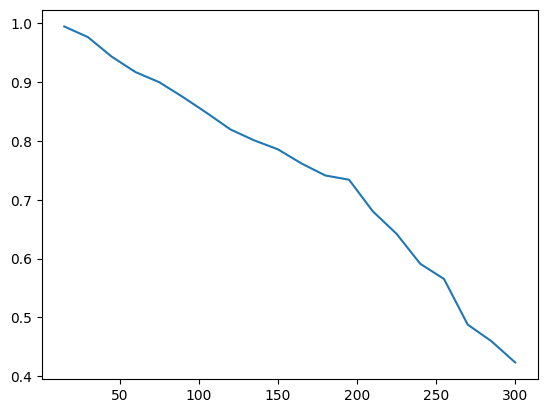

In [11]:
y_pred.mean().plot.line();

## Neighbors

We can also use our model for querying comparables based on survivability.

In [12]:
neighbors = xgbse_model.get_neighbors(
    query_data=X_test, index_data=X_train, n_neighbors=5
)

print(neighbors.shape)
neighbors.head(5)

(635, 5)


,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5
829,1589,339,738,1710,1570
670,1082,605,1022,864,891
1064,1207,1230,416,1252,1750
85,8,1080,703,1522,234
1814,693,1743,819,859,941


<b>example</b>: selecting a data point from query data (X_test) and checking its features

In [13]:
desired = neighbors.iloc[10]

X_test.loc[X_test.index == desired.name]

,x0,x1,x2,x3,x4,x5,x6,x7,x8
399,5.572504,7.367552,11.023443,5.406307,1.0,0.0,0.0,1.0,67.620003


... and finding its comparables from index data (X_train)

In [14]:
X_train.loc[X_train.index.isin(desired.tolist())]

,x0,x1,x2,x3,x4,x5,x6,x7,x8
1522,5.787038,6.713382,11.090166,5.551950,0.0,0.0,0.0,1.0,68.250000
703,5.823333,7.185800,10.898102,5.538811,0.0,0.0,0.0,1.0,66.540001
968,5.541239,7.058089,10.463409,5.396433,1.0,0.0,0.0,1.0,71.070000
1640,5.812605,7.646811,10.952687,5.516386,1.0,1.0,0.0,1.0,68.559998
234,5.784350,6.797296,11.025448,5.335426,1.0,1.0,0.0,1.0,68.489998


## Score metrics

XGBSE implements concordance index and integrated brier score, both can be used to evaluate model performance

In [15]:
# importing metrics
from xgbse.metrics import concordance_index, approx_brier_score

# running metrics
print(f"C-index: {concordance_index(y_test, y_pred)}")
print(f"Avg. Brier Score: {approx_brier_score(y_test, y_pred)}")

C-index: 0.6336272856034563
Avg. Brier Score: 0.263349836341085


## Cross Validation

We can also use sklearn's cross_val_score and make_scorer to cross validate our model

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

results = cross_val_score(xgbse_model, X, y, scoring=make_scorer(approx_brier_score))
results

/home/gabrielgimenez/work/xgboost-survival-embeddings/xgbse/_debiased_bce.py:212: RuntimeWarning: Warning: Only one class found in a time bucket
  warnings.warn(


array([0.17746338, 0.16216138, 0.1405086 , 0.17718197, 0.17015665])